# Chapter 4 - Policy gradients methods
### REINFORCE method

This notebook implements a REINFORCE algorithm. The policy network accepts
state vectors as inputs and produces a (discrete) probability distribution over the possible actions.

The code and theory is based on Alexander Zai. “Deep Reinforcement Learning in Action MEAP V06”. Manning publications. 

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
from collections import OrderedDict
from torch.autograd import Variable
from IPython.display import clear_output
import torch.distributed as dist


In [2]:
env = gym.make("CartPole-v0")

/Users/jluissamper/.virtualenvs/pytorch/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
# test environment
def testEnv(env, steps = 200):
    env.reset()
    for _ in range(steps):
        env.render()
        env.step(env.action_space.sample()) # take a random action
    env.close()

In [4]:
# Unconmment to check everything is properly installed
# A window with a cartpole randomly moving should appear. 
# Some python3-related errors might occur after closing the environment (window with the cartpole)
# Check whether kernel needs to be restarted 
 testEnv(env, 100)

/Users/jluissamper/.virtualenvs/pytorch/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [28]:
class REINFORCE():
    def __init__(self, n_in, n_out, n_hidden1, n_hidden2, env, gamma = 0.9):
        self.n_in = n_in
        self.n_out = n_out
        self.env = env
        self.gamma = gamma
        
       # self.one_hot_reward = np.ones(arms)

        # Neural network model definition 
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(n_in, n_hidden1)),
            ('ReLu1', nn.LeakyReLU(inplace = True)),
            ('fc2', nn.Linear(n_hidden1, n_hidden2)),
            ('ReLu2', nn.LeakyReLU(inplace = True)),
            ('fc3', nn.Linear(n_hidden2, n_out)),
            ('softmax', nn.Softmax(dim=0))
        ])
        )
       # self.TNetwork = copy.deepcopy(self.QNetwork) # Target Network
       # self.TNetwork.load_state_dict(self.QNetwork.state_dict())                
    def updateEnv (self, env):
        self.env = env
        
    def playEpisode(self, eps_max_dur, init_state, preds):
        transitions_ = []
        state_ = init_state
        for st in range(eps_max_dur): 
            action_, pred_ = self.policy.step(self.model, state_, self.n_out)
            new_state_, reward_, done = self.policy.execAction(self.env, action_)
            transitions_.append((state_, action_, st+1))
            preds[st] = pred_[action_]
            if done:
                break
            state_ = new_state_

        return transitions_
        
    def resetEnv(self):
        state = self.env.reset()
        return state
    class policy():
        
        def step(model, state, n_outs):
            pred = model(torch.from_numpy(state).float())
            action = np.random.choice(np.array(range(n_outs)), p = pred.data.numpy())
            return action, pred
            
        def execAction (env, action):
            new_state, reward, done, info = env.step(action)
            return new_state, reward, done
        
        def discount_rewards(rewards, disc_factor=0.99):
            # create the discount array using the disc factor and multiply it by the rewards
            disc_rewards = torch.pow(disc_factor,torch.arange(len(rewards)).float()) * rewards 
            # Normalize rewards so as to avoid drift/shift in training
            # Add small num to den so as to avoid 0 div
            norm_dreward = (disc_rewards - disc_rewards.mean()) / (disc_rewards.std() + 1e-09) 
            return norm_dreward
        
        # to train the network:
        # 1. Calculate prob of the action taken
        # 2. Apply discount factor
        # 3. backpropagate and minimize the loss

In [29]:
learning_rate = 0.0009
l1 = 4
l2 = 150
l3 = 100
l4 = 2

In [30]:
RLmodel = REINFORCE(l1,l4,l2,l3, env)
optimizer = torch.optim.Adam(RLmodel.model.parameters(), lr = learning_rate)

In [31]:
testR = torch.Tensor([4, 3, 2, 1])
RLmodel.policy.discount_rewards(testR)

tensor([ 1.1695,  0.3796, -0.3949, -1.1542])

In [32]:
def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))

In [36]:
MAX_DUR = 200
MAX_EPISODES = 1000 
gamma_ = 0.99 # discount factor
RLmodel.updateEnv(gym.make("CartPole-v0")) 
score = []

for episode in range(MAX_EPISODES):
    init_state = RLmodel.resetEnv()
    pred_batch = torch.zeros(MAX_DUR)
    done = False 
    t = 0
    obs = [] 
    actions = []
    history = RLmodel.playEpisode(MAX_DUR, init_state, pred_batch)
    ep_len = len(history) 
    score.append(ep_len)
    print(history)
    # Get rewards of the episode and discount-normalize them 
    reward_batch = torch.Tensor([r for (s,a,r) in history]).flip(dims=(0,))
    disc_returns = RLmodel.policy.discount_rewards(reward_batch, gamma_)
    # Get states the system has gone through
    state_batch = torch.Tensor([s for (s,a,r) in history])
    # Get actions
    action_batch = torch.Tensor([a for (s,a,r) in history])
    # Recompute the prediction corresponding to the action taken in each step
    #pred_batch = RLmodel.model(state_batch)
    
    print(pred_batch)
    #pred_batch = torch.tensor(pred_batch)
    #prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()
    # backpropagate and update
    loss = loss_fn(pred_batch[0:ep_len], disc_returns)
    print(episode, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clear_output(wait=True)


[(array([ 0.04175637, -0.00106017, -0.02931708, -0.03768616]), 1, 1), (array([ 0.04173517,  0.19446966, -0.0300708 , -0.33947285]), 0, 2), (array([ 0.04562456, -0.0002118 , -0.03686026, -0.05642217]), 0, 3), (array([ 0.04562033, -0.19478638, -0.0379887 ,  0.22440698]), 0, 4), (array([ 0.0417246 , -0.38934537, -0.03350056,  0.50486892]), 1, 5), (array([ 0.03393769, -0.19376771, -0.02340318,  0.20181972]), 0, 6), (array([ 0.03006234, -0.38854728, -0.01936679,  0.48702915]), 0, 7), (array([ 0.02229139, -0.58339068, -0.00962621,  0.77354598]), 1, 8), (array([ 0.01062358, -0.38813763,  0.00584471,  0.4778499 ]), 1, 9), (array([ 0.00286083, -0.19309869,  0.01540171,  0.18701482]), 1, 10), (array([-0.00100115,  0.00179956,  0.01914201, -0.10076995]), 0, 11), (array([-0.00096515, -0.19359142,  0.01712661,  0.19789023]), 0, 12), (array([-0.00483698, -0.3889541 ,  0.02108441,  0.49592625]), 1, 13), (array([-0.01261607, -0.19413572,  0.03100294,  0.20996199]), 0, 14), (array([-0.01649878, -0.3896

In [37]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [38]:

score = np.array(score)
avg_score = running_mean(score, 50)

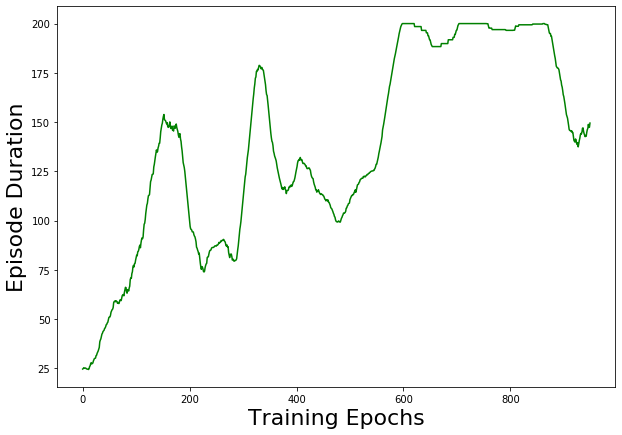

In [39]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

### In some approaches preds are recomputed after playing the full action. Why?